<Time tt=[2458446.500800741 ... 2458451.5001062965] len=7200>


Text(0.5, 1.0, 'FOX-1B elevation @ EM15\n2018-11-24T00:00:00Z to 2018-11-28T23:59:00Z')

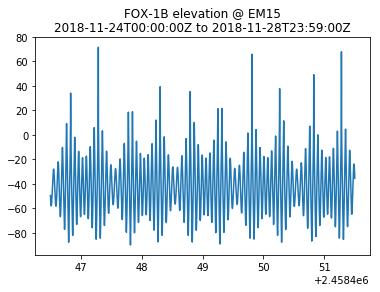

In [12]:
'''
2018-11-20
following along with <https://github.com/skyfielders/astronomy-notebooks/blob/master/Solvers/Earth-Satellite-Passes.ipynb>
'''

import math

from skyfield.api import load, Topos, earth, JulianDate
import matplotlib.pyplot as plt
from scipy import optimize
import maidenhead as mh
import numpy as np

ts = load.timescale()

tau = 2.0 * np.pi

'''CONFIGURE ME!!!!'''
tle = load.tle('data/tle/amateur.txt')
src_mh = 'EM15'
satellite = 'FOX-1B'
#satellite = 'AO-92'
window_start = (2018, 11, 24)
window_days = 5.0
min_altitude = 30.0
time_above = 15.0

# do every minute for 24 hours starting on 2018-11-19 0000Z UTC
window_minutes = 24 * 60 * window_days
time_range = ts.utc(*window_start, 0, range(int(window_minutes)))

home = Topos(*mh.toLoc(src_mh))
sat = tle[satellite]

diff = sat - home

def alt_f(t):
    return diff.at(t).altaz()[0].degrees

print(time_range)
altitudes = alt_f(time_range)
plt.plot(time_range.tai, altitudes)
plt.title('{} elevation @ {}\n{} to {}'.format(
        satellite
        , src_mh
        , time_range[0].utc_iso()
        , time_range[-1].utc_iso()
    )
)

In [8]:
# sample six points per orbit to improve performance
orbit_period_per_minute = tau / sat.model.no
orbit_period = orbit_period_per_minute / window_minutes
revolutions_in_window = 1.0 / orbit_period # approximate number of peaks
sample_points = revolutions_in_window * 6.0
sample_step = int(math.floor(window_minutes / sample_points))
print(revolutions_in_window, 'revolutions in window')
print(orbit_period_per_minute, 'orbital period per minute')
print(orbit_period / 6.0, 'orbit period')
print(sample_points, 'sample points (revs*6)')
sample_time_range = ts.utc(*window_start, 0, range(0, int(math.ceil(window_minutes)), sample_step))
print(sample_time_range)

sample_altitudes = alt_f(sample_time_range)

73.9606133870416 revolutions in window
97.34911151049876 orbital period per minute
0.0022534516553356196 orbit period
443.7636803222496 sample points (revs*6)
<Time tt=[2458446.500800741 ... 2458451.48968963] len=450>


73 sample peaks


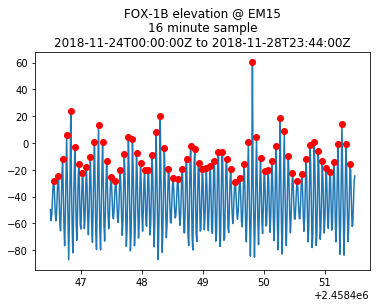

In [9]:
left_diff = np.ediff1d(sample_altitudes, to_begin=0.0)
right_diff = np.ediff1d(sample_altitudes, to_end=0.0)
maxima = (left_diff > 0.0) & (right_diff < 0.0)
print(sum(maxima), 'sample peaks')
plt.plot(sample_time_range.tai, sample_altitudes)
plt.title('{} elevation @ {}\n{} minute sample\n{} to {}'.format(
        satellite
        , src_mh
        , sample_step
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(sample_time_range[maxima].tai, sample_altitudes[maxima], 'ro')

<Time tt=[2458446.5563562964 ... 2458451.411911852] len=73>


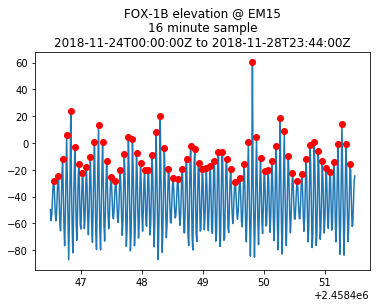

In [10]:
def alt_f_minimization_wrapper(t):
    return -alt_f(ts.tai_jd(t))

def find_highest(t, step):
    result = optimize.minimize_scalar(alt_f_minimization_wrapper, bracket=[t.tai + step, t.tai - step], tol=(1.0 / 24.0 / 60.0 / 60.0) / t.tai)
    return result.x

print(sample_time_range[maxima])
t_highest = ts.tai_jd([find_highest(ti, (window_minutes / sample_points) / (60 * 24)) for ti in sample_time_range[maxima]])
plt.plot(sample_time_range.tai, sample_altitudes)
plt.title('{} elevation @ {}\n{} minute sample\n{} to {}'.format(
        satellite
        , src_mh
        , sample_step
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(sample_time_range[maxima].tai, sample_altitudes[maxima], 'ro')

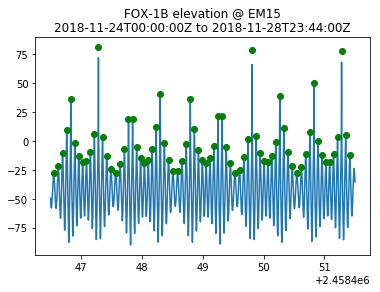

In [11]:
plt.title('{} elevation @ {}\n{} to {}'.format(
        satellite
        , src_mh
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(time_range.tai, altitudes)
plt.plot([_.tai for _ in t_highest], alt_f(t_highest), 'go')

In [19]:
def rising_setting_wrapper(t):
    return -alt_f_minimization_wrapper(t)

def find_rising(t, step):
    return optimize.brentq(rising_setting_wrapper, t.tai - (2 * step), t.tai)

def find_setting(t, step):
    return optimize.brentq(rising_setting_wrapper, t.tai + (2 * step), t.tai)

passes = ts.tai_jd([_.tai for _ in t_highest if alt_f(_) > min_altitude])
rising = ts.tai_jd([find_rising(_, (window_minutes / sample_points) / (24 * 60)) for _ in passes])
setting = ts.tai_jd([find_setting(_, (window_minutes / sample_points) / (24 * 60)) for _ in passes])

for start, peak, stop in zip(rising, passes, setting):
    print(start.utc_iso(), peak.utc_iso(), stop.utc_iso())

2018-11-24T07:58:28Z 2018-11-24T07:53:12Z 2018-11-24T08:04:05Z
2018-11-24T18:52:38Z 2018-11-24T18:46:00Z 2018-11-24T18:58:31Z
2018-11-25T19:14:25Z 2018-11-25T19:08:00Z 2018-11-25T19:20:11Z
2018-11-26T07:05:38Z 2018-11-26T07:00:16Z 2018-11-26T07:11:27Z
2018-11-27T07:27:26Z 2018-11-27T07:21:55Z 2018-11-27T07:33:27Z
2018-11-27T18:21:39Z 2018-11-27T18:15:27Z 2018-11-27T18:27:13Z
2018-11-28T07:49:11Z 2018-11-28T07:43:44Z 2018-11-28T07:55:10Z
2018-11-28T18:43:24Z 2018-11-28T18:37:04Z 2018-11-28T18:49:05Z
